In [17]:
# importing libraries
import numpy as np
import pandas as pd
from PIL import Image
import torch
import tensorflow as tf
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import pickle as pkl
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import sklearn
import seaborn as sns
import cv2
import skimage.exposure
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [2]:
csv_data = pd.read_csv('./blocks-labels.csv')
print(csv_data[:3])
print('Number of stable:',np.count_nonzero(csv_data.stable==1))
print('Number of unstable:',np.count_nonzero(csv_data.stable==0))

   id  stable
0   1       1
1   2       1
2   3       1
Number of stable: 27034
Number of unstable: 24242


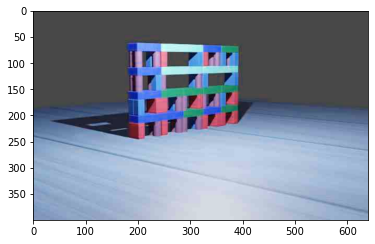

In [3]:

# load image
img = cv2.imread('./archive/23.jpg')
plt.imshow(img)

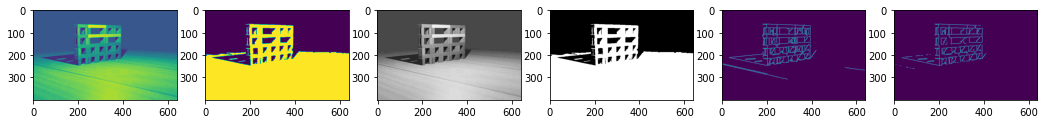

In [47]:
### image processing 
# take out background, remove light 
# increase contrast, maybe rgb vs greyscale? 

# convert to gray
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# threshold
thresh = cv2.threshold(gray, 90, 255, cv2.THRESH_BINARY)[1]

# put mask on back
mask_back = cv2.cvtColor(gray, cv2.COLOR_BGR2BGRA)

mask_thresh = cv2.cvtColor(thresh, cv2.COLOR_BGR2BGRA)

# canny edge 
edges = cv2.Canny(img,100,230)
edges1 = cv2.Canny(img,230,250)

fig, ax = plt.subplots(1,6,figsize=(18, 18))

ax[0].imshow(gray)
ax[1].imshow(thresh)
ax[2].imshow(mask_back)
ax[3].imshow(mask_thresh)
ax[4].imshow(edges)
ax[5].imshow(edges1)
# ax[0][1] = plt.imshow(thresh)

In [ ]:
# AlexNet

